In [1]:
# In a notebook cell:
!pip install scanpy==1.10 squidpy==1.3 celltypist==1.6 cellchat==1.1 \
             matplotlib seaborn pandas numpy scipy scikit-learn


ERROR: Could not find a version that satisfies the requirement cellchat==1.1 (from versions: none)
ERROR: No matching distribution found for cellchat==1.1


In [2]:
# In a VSCode/Jupyter cell:
!pip install scanpy==1.10 squidpy==1.3 celltypist==1.6 \
             matplotlib seaborn pandas numpy scipy scikit-learn


# 1 · Load and QC the single‑nucleus RNA‑seq data
First we load the raw count matrix, gene annotations and cell metadata.  
We’ll print a few basic stats to make sure the files line up before proceeding.


In [3]:
# Code 1 – Imports & file paths
import scanpy as sc, pandas as pd, numpy as np, os, seaborn as sns, matplotlib.pyplot as plt

RAW_DIR = "../data"          # ← adjust if needed
MTX    = os.path.join(RAW_DIR, "DGE.mtx")
GENES  = os.path.join(RAW_DIR, "all_genes.csv")
META   = os.path.join(RAW_DIR, "cell_metadata.csv")

print("✓ Libraries imported")


c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecat

✓ Libraries imported


In [4]:
# Code 2 – Read files into AnnData with explicit checks


# 1) Load the raw sparse matrix
mtx = sc.read_mtx(MTX)  # shape = (rows, cols)
print("raw MTX shape (rows×cols):", mtx.shape)

# 2) Decide whether to transpose
genes_df = pd.read_csv(GENES)
n_genes  = genes_df.shape[0]
if mtx.shape[0] == n_genes:
    # rows == genes → we need transpose
    adata = sc.AnnData(mtx.T)
    print("Transposed → AnnData shape (cells×genes):", adata.shape)
elif mtx.shape[1] == n_genes:
    # cols == genes → no transpose
    adata = sc.AnnData(mtx)
    print("AnnData shape (cells×genes):", adata.shape)
else:
    raise ValueError(
        f"Neither dim of MTX ({mtx.shape}) matches {n_genes} genes")

# 3) Assign gene metadata
assert adata.n_vars == n_genes, \
    f"Expected {n_genes} genes, found {adata.n_vars}"
adata.var["gene_id"]   = genes_df["gene_id"].values
adata.var["gene_name"] = genes_df["gene_name"].values
adata.var_names        = adata.var["gene_id"]

# 4) Load & attach cell metadata
meta = pd.read_csv(META, index_col=0)
assert adata.n_obs == meta.shape[0], \
    f"Expected {meta.shape[0]} cells, found {adata.n_obs}"
adata.obs = meta

print("✓ MTX, VAR (genes) and META (cells) all aligned")


raw MTX shape (rows×cols): (92384, 54232)
AnnData shape (cells×genes): (92384, 54232)
✓ MTX, VAR (genes) and META (cells) all aligned


## 2 · Basic quality control (mitochondrial % and gene counts)
We remove low-quality nuclei – fewer than 500 genes or more than 5 % mitochondrial reads.


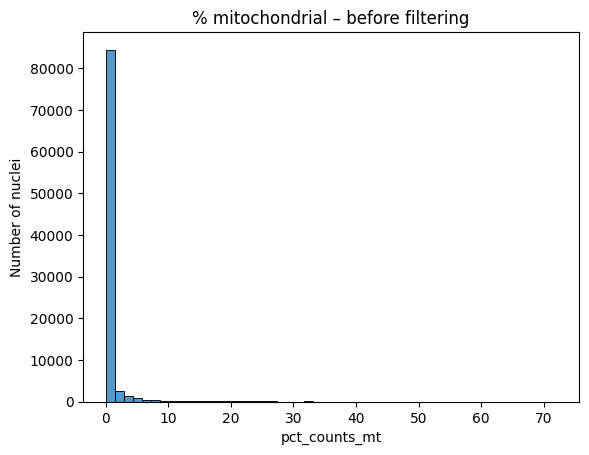

Kept 69897/92384 nuclei (75.7%) after QC


In [5]:
# Code 3 – QC flags
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Flag mitochondrial genes
adata.var["mt"] = adata.var["gene_name"].str.startswith(("mt-","MT-"))

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Visual check before filtering
sns.histplot(adata.obs["pct_counts_mt"], bins=50)
plt.title("% mitochondrial – before filtering")
plt.xlabel("pct_counts_mt")
plt.ylabel("Number of nuclei")
plt.show()

# Filtering
pre = adata.n_obs
adata = adata[ 
    (adata.obs.n_genes_by_counts > 500) &
    (adata.obs.pct_counts_mt   < 5)
].copy()

print(f"Kept {adata.n_obs}/{pre} nuclei ({adata.n_obs/pre:.1%}) after QC")


## 3 · Normalisation, HVG selection and PCA
We log-transform counts, pick 2 000 highly variable genes and compute 50 PCs.


HVGs selected: 2000


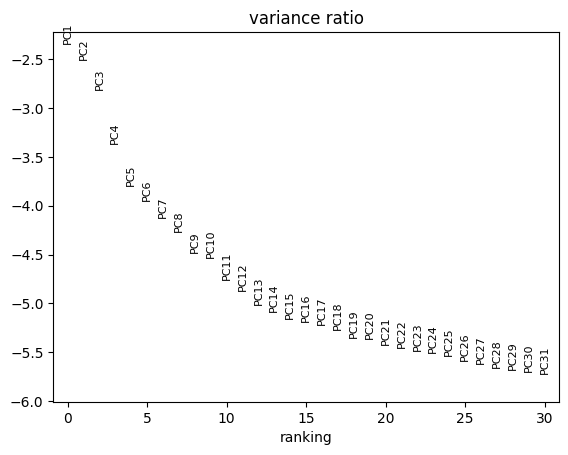

In [6]:
# Code 4 – Normalise → log1p, HVG, PCA
import scanpy as sc

# Total-count normalisation and log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Select 2,000 highly variable genes (Seurat flavour)
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    subset=True, 
    flavor="seurat"
)
print("HVGs selected:", adata.n_vars)

# PCA & variance ratio plot
sc.pp.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata, log=True, show=True)


## 4 · Neighbour graph, clustering and UMAP
We build a 30-nearest-neighbour graph on the PCs, run Leiden clustering (resolution = 1.0) and visualise in 2-D with UMAP.


C:\Users\viraj\AppData\Local\Temp\ipykernel_31228\842456485.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


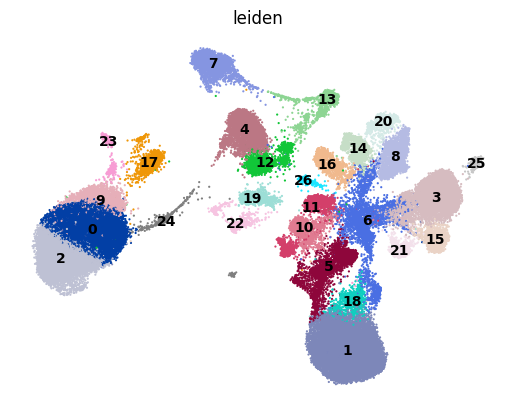

In [7]:
# Code 5 – Graph & UMAP
import scanpy as sc

# Neighbour graph on 50 PCs
sc.pp.neighbors(
    adata, 
    n_neighbors=30, 
    n_pcs=50, 
    metric="cosine"
)

# UMAP embedding
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, resolution=1.0)

# Plot clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    legend_loc="on data",
    frameon=False,
    size=10,
    show=True
)


## 5 · Cell-type annotation with CellTypist (quick draft)
CellTypist uses a pre-trained mouse-brain model to label each Leiden cluster.  
We print a table of cluster → suggested type for sanity checking.


⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 69897 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 1 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


celltype
Double-positive thymocytes    68492
Epithelial cells               1405
Name: count, dtype: int64


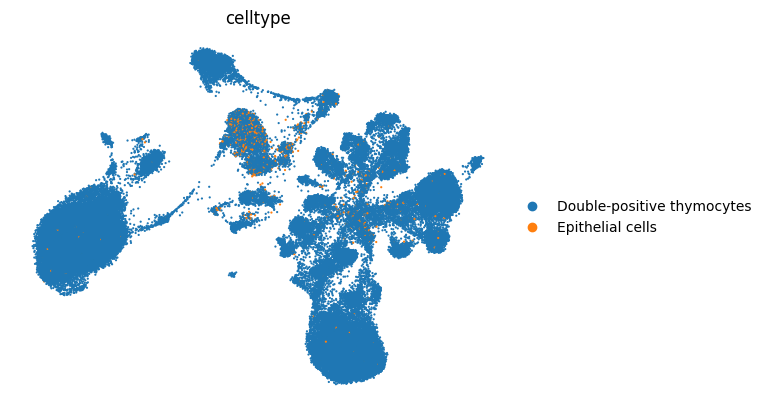

In [8]:
# Code 6 – CellTypist annotation (robust label extraction)
import celltypist
import pandas as pd
import scanpy as sc

# 1) Copy AnnData & switch to gene symbols
adata_cp = adata.copy()
adata_cp.var_names = adata_cp.var["gene_name"].values
adata_cp.var_names_make_unique()

# 2) Load model & annotate
model = celltypist.models.Model.load("Immune_All_Low.pkl")
pred  = celltypist.annotate(
    adata_cp,
    model=model,
    majority_voting=True
)

# 3) Extract just the labels as a Series
labels = pred.predicted_labels
if isinstance(labels, pd.DataFrame):
    # grab the first column if it's a DataFrame
    labels = labels.iloc[:, 0]
labels.index = adata_cp.obs_names  # ensure the index matches cells

# 4) Assign back to your original adata, aligned by cell name
adata.obs["celltype"] = labels.reindex(adata.obs_names).values

# 5) Inspect & plot
print(adata.obs["celltype"].value_counts().head(12))
sc.pl.umap(
    adata,
    color="celltype",
    legend_loc="right margin",
    frameon=False,
    size=10,
    show=True
)


In [9]:
# Code 7 – Save processed AnnData
adata.write_h5ad("sn_preprocessed.h5ad", compression="gzip")
print("✓ Saved to sn_preprocessed.h5ad")


✓ Saved to sn_preprocessed.h5ad
